# What's in an online dating profile? 

People say a lot about themselves in online dating profiles, especially on sites like OKCupid that encourage people to answer questions. Thus, we can learn a lot about people by studying what they write. OKC has made some of their profile data from San Fransisco public. We will be using that data in this lab to explore different cultural questions. 

Our first question is whether and how men and women talk about themselves differently in their profiles. Popular culture is constantly telling us that men and women have different interests, hobbies, and relationship goals. Yet there are also many examples of women who like stereotypically masculine things and men who like feminine ones. This is especially interesting in online dating, because people are seeking partners with similar interests and relationship goals. Finding a partner would be hard for straight men and women if these two groups had very different interests. 

OKC shared 59,946 profiles though -- way too many to read! Computers can read them all and tell us how common different words are. So our first approach will be simple. We can ask 
1. Which words are used the most by men and women? 
2. Which words are used often by men but not women, and vice versa? 

At the end of the lab, you'll be able to ask this question about other social groups too (like sexual orientation, race/ethnicity, age, level of education, even whether someone likes dogs or cats).

# 0. Setup
### Import the libraries we'll use.
`%matplotlib inline` lets us see charts and plots right here in the notebook!

In [1]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize 
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
from collections import Counter

%matplotlib inline

### Read our data.
**Before you run this code:** make sure that you have downloaded the data.
- Go to [https://github.com/rudeboybert/JSE_OkCupid](https://github.com/rudeboybert/JSE_OkCupid). 
    - If you're new to github, the easiest way is to right-click each file and "save link as." You can also clone or download the whole repository. 
- Download the `okcupid_codebook.txt` and `profiles.csv.zip` files and save them in the `data` directory (folder).
- Unzip the profiles file in the same place.

In [2]:
profiles = pd.read_csv('data/profiles.csv')

In [3]:
#Show how many rows and columns the data has
profiles.shape

(59946, 31)

In [6]:
#show the names of the columns
profiles.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'orientation', 'pets',
       'religion', 'sex', 'sign', 'smokes', 'speaks', 'status'],
      dtype='object')

In [5]:
#show the first few rows of data
profiles.head()

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,...,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...",...,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,...,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,...,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available
3,23,thin,vegetarian,socially,NaN,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,...,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
4,29,athletic,NaN,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,i smile a lot and my inquisitive nature,...,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single


### First, a little housekeeping...
You don't need to worry about the code here right now. Just run it and continue reading below. Expand for more details on how it works.

- The OKC data has 10 different columns with profile text, one for each long-answer question in users' profiles. We want to look at all of the profile text, so this merges it all together in a new column called `text`.
- This code also simplifies the categories people pick for other things like level of education, the pets they have, etc.
- It removes people under 18 and over 60.
- It saves this cleaner version of the data so we can use it later.

### The code
This cell tells python a bunch of information about our data.

In [7]:
essay_cols = ['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 
              'essay7', 'essay8', 'essay9']

ed_levels = {'<HS': ['dropped out of high school', 'working on high school'],
             'HS': ['graduated from high school', 'working on college/university', 
                    'two-year college', 'dropped out of college/university', 
                    'high school'], 
             'BA': ['graduated from college/university', 
                    'working on masters program', 'working on ph.d program', 
                    'college/university', 'working on law school', 
                    'dropped out of masters program', 
                    'dropped out of ph.d program', 'dropped out of law school', 
                    'dropped out of med school'],
             'Grad_Pro': ['graduated from masters program',
                          'graduated from ph.d program',                           
                          'graduated from law school', 
                          'graduated from med school', 'masters program', 
                          'ph.d program', 'law school', 'med school']
            }

bodies = {'average': ['average'], 
          'fit': ['fit', 'athletic', 'jacked'], 
          'thin': ['thin', 'skinny'], 
          'overweight': ['curvey', 'a little extra', 'full figured', 'overweight']
         }

smoke = {'no': ['no'], np.nan: ['nan']}

kids = {'yes': ['has a kid', 'has kids']}

has_pets = {'yes': ['has']}

ethn = {'White': ['white', 'middle eastern', 'middle eastern, white'], 
        'Asian': ['asian', 'indian', 'asian, pacific islander'], 
        'Black': ['black']
       }   

ethn2 = {'Latinx': ['latin'], 'multiple': [','], np.nan: ['nan']}   

drinks = {'no': ['rarely', 'not at all']}

drugs = {'no': ['never']}

jobs = {'education': ['student', 'education'], 
        'STEM': ['science', 'computer'], 
        'business': ['sales', 'executive', 'banking'], 
        'creative': ['artistic', 'entertainment'], 
        'med_law': ['medicine', 'law'],
        np.nan: ['nan']
       }

religion = {'none': ['agnosticism', 'atheism'],
            'catholicism': ['catholicism'],
            'christianity': ['christianity'],
            'judaism': ['judaism'],
            'buddhism': ['buddhism'],
            np.nan: ['nan']
           }

languages = {'multiple': [',']}

This cell defines some functions we'll use to clean up the data.

In [8]:
def concat(row, cols):
    tmp = []
    for c in cols:
        tmp.append(str(row[c]))
    new = '\n'.join(tmp)
    return new

def recode(text, dictionary, default=np.nan):
    '''Function for recoding categories in a column based on exact matches'''
    out = default
    text = str(text)
    
    for x in dictionary.keys():
        for y in dictionary[x]:
            if y == text: #exact match
                out = x
                return out
    return out

def recode_fuzzy(text, dictionary, default=np.nan):
    '''Function for recoding categories in a column based on partial matches'''
    out = default
    text = str(text)
    
    for x in dictionary.keys():
        for y in dictionary[x]:
            if y in text: #partial match
                out = x
                return out
    return out


def which_pets(t, criterion='has'):
    '''Function for determining which pets someone has or likes'''
    d = False
    c = False
    t = str(t)
    p = 'neither'
    if t == 'nan':
        p = np.nan
    
    if 'has dogs' in t:
        d = True
    if 'has cats' in t:
        c = True
        
    if criterion == 'likes':
        if 'likes dogs' in t:
            if 'dislikes dogs' not in t:
                d = True
        if 'likes cats' in t:
            if 'dislikes cats' not in t:
                c = True
        
    if c and d:
        p = 'both'
    elif c:
        p = 'cats'
    elif d:
        p = 'dogs'
        
    return p

def census_2010_ethnicity(t):
    '''
    Function gathers choices for this question gathered by the US Census 2010.
    It deviates from the census by creating exclusive Latinx category. Selecting 
    just 'latin' and nothing else was the 3rd most frequent ethnicity in this 
    data. The discision to include people who identified 'latin' and another race
    is based in research on Latinx people's experience with the US Census, but 
    like all racial and ethnic categorization systems, it is flawed. 
    '''
    text = str(t)
    
    e = recode(text, ethn, default='other')
    if 'other' == e:
        e = recode_fuzzy(text, ethn2, default='other')
    
    return e

def height(inches):
    h = 'under_6'
    if inches >= 72:
        h = 'over_6'
    return h

#### Do the clean up
This cell calls the functions we created in the last cell, along with the information about our data from the cell before it, to actually clean our data.

In [9]:
#remove people 60+ and 17-
profiles = profiles[(profiles.age < 60) & (profiles.age > 17)]

#recode categorical columns into simpler categories
profiles['text'] = profiles.apply(concat, axis=1, cols=essay_cols)
profiles['edu'] = profiles.education.apply(recode, dictionary=ed_levels, 
                                            default='unknown')
profiles['kids'] = profiles.offspring.apply(recode_fuzzy, dictionary=kids, 
                                            default='no')
profiles['pets_likes'] = profiles.pets.apply(which_pets, criterion='likes')
profiles['pets_has'] = profiles.pets.apply(which_pets, criterion='has')
profiles['pets_any'] = profiles.pets.apply(recode_fuzzy, dictionary=has_pets, 
                                            default='no')
profiles['age_group'] = profiles.age.apply(lambda x: str(int(x/10)*10))
profiles['height_group'] = profiles.height.apply(height)
profiles['race_ethnicity'] = profiles.ethnicity.apply(census_2010_ethnicity)
profiles['smoker'] = profiles.smokes.apply(recode, dictionary=smoke, 
                                            default='yes')
profiles['body'] = profiles.body_type.apply(recode, dictionary=bodies, 
                                            default='unknown')
profiles['alcohol_use'] = profiles.drinks.apply(recode, dictionary=drinks, 
                                            default='yes')
profiles['drug_use'] = profiles.drugs.apply(recode, dictionary=drugs, 
                                            default='yes')
profiles['industry'] = profiles.job.apply(recode_fuzzy, dictionary=jobs, 
                                            default='other')
profiles['religion'] = profiles.religion.apply(recode_fuzzy, dictionary=religion, 
                                            default='other')
profiles['languages'] = profiles.speaks.apply(recode_fuzzy, dictionary=languages, 
                                            default='English_only')

# keep just these columns
profiles = profiles[['age_group', 'age', 'body', 'alcohol_use', 'drug_use', 'edu', 
                     'race_ethnicity', 'height_group', 'industry', 'kids', 
                     'orientation', 'pets_likes', 'pets_has', 'pets_any', 
                     'religion', 'sex', 'smoker', 'languages', 'text', 'essay0', 
                     'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 
                     'essay7', 'essay8', 'essay9']]

profiles.head()

,age_group,age,body,alcohol_use,drug_use,edu,race_ethnicity,height_group,industry,kids,...,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,20,22,overweight,yes,no,HS,multiple,over_6,other,no,...,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...","books:<br />\nabsurdistan, the republic, of mi...",food.<br />\nwater.<br />\ncell phone.<br />\n...,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet!<br />\nyou...
1,30,35,average,yes,yes,unknown,White,under_6,other,no,...,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories.<br /...,NaN,NaN,i am very open and will share just about anyth...,NaN
2,30,38,thin,yes,yes,Grad_Pro,NaN,under_6,NaN,no,...,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement<br />\nconversation<br />\ncreation<b...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,20,23,thin,yes,yes,HS,White,under_6,education,no,...,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . .<br />\nlynch, j...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.
4,20,29,fit,yes,no,BA,multiple,under_6,creative,no,...,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians<br />\nat the...",NaN,NaN,NaN,NaN,NaN


#### Save the results
This cell saves the cleaned up data to a file so we can use it again later.

In [10]:
profiles.to_csv('data/clean_profiles.tsv', sep='\t', index=False)

### For laptop or personal computer users
Run this code so that you're working with a smaller amount of data and don't crash your computer. It takes a simple random sample of the data.

In [11]:
profiles = profiles.sample(20000)
profiles = profiles.reset_index(drop=True)

### While we're at it, let's make some helper functions for later.
Run this code, but don't worry about these now.

In [12]:
def extract_example(text, word, context=False):
    #regex for selecting the whole word from a stem
    expr = word + '\w*'
    
    if context:
        #regex for selecting a stem and also the 2 words before and after it
        #this lets us see the context in which it is used
        expr = '\w*\W*\w*\W*' + word + '\w*\W*\w*\W*\w*'

    return re.search(expr, text, re.I).group()

def get_examples(data, word, n=5, context=True, limit_col=None, limit_val=None):
    if word.endswith('i'):
        #the Porter2 stemmer sometimes adds 'i' to stems. This trimms it off.
        word = word[:-1]
    
    #restrict to just some group of interest
    if limit_col is not None:
        data = data[data[limit_col] == limit_val]
    
    #sample our data so this operation goes faster
    if data.shape[0] > 1000:
        data = data.sample(1000)
    
    #find profiles with the word in them
    tmp = data.text.apply(lambda x: word in x)
    #select n random profiles that have the word
    count = tmp.sum()
    
    #if we wanted more examples than there are
    if n > count:
        n = count
    tmp2 = data[tmp].text.sample(n).values
    
    #get an example out of each profile we selected
    tmp = []
    for t in tmp2:
        tmp.append(extract_example(t, word, context))
    
    return tmp

def unstem(word, data, n=50):
    if word.endswith('i'):
        #the Porter2 stemmer sometimes adds 'i' to stems. This trimms it off.
        word = word[:-1]

    #use the function we made before to get examples of the stem
    tmp = get_examples(data, word=word, n=n, context=False)
    
    #count up and return the most common form of the word matching the stem
    return Counter(tmp).most_common(1)[0][0]

def clean_index(df, text):
    #replaces stems in the index of a dataframe with whole words
    df.reset_index(inplace=True)
    df['index'] = df['index'].apply(unstem, data=text)
    df.set_index('index', inplace=True)
    return df

# 1. Tokenizing text

#### Let's peak at an example of the text so we know what we're working with.
This code shows us the text for the 6th profile (python counts from 0, so the first profile is #0, the second is #1, and so on). 5 here could be any number. Try changing it to see.

In [13]:
profiles.text[5]

"highly recommend not having margarita come out of your nose because\nyou're laughing too hard- burns like a mother f'er. hate pdpg\n(public displays of personal grooming, i.e., flossing, nail\ncutting, etc.). freeze up when i'm the center of attention but can\nbe reasonably charming in a small group. melt when i see men buying\nflowers. stop at every lost pet poster and say a little prayer.\ncan't cook worth a damn. get spanked by the big waves, but can ride\na mean ocean ripple. own a few power tools. got soul but i'm not a\nsoldier. appreciate the time i had with my grandfather. admire\nwriters. have accepted that i'm not a yoga person. boulder a v3 but\nplan on tackling v4s by year's end. (want to climb with me?) died\nin a dream but woke up to tell about it. know i'd mess up the star\nspangled banner if invited to perform at a baseball game. get\nteary-eyed when i hear the song this year's love by david gray.\nbelieve in saying please and thank you. have traveled to heaven and\nhe

### We want to split the text into words so we can count them. Here's a simple first try.
- The `split()` function, like its name suggests, splits text into chunks. If we split on spaces (the default), it will split the text into words. Let's `apply` it to the `text` of our `profiles`.
- Notice that this is a little messy. The punctuation and some HTML things are mixed in with our words.

In [14]:
tmp = profiles['text'].apply(lambda x: x.split())
tmp.head()

0    [crap., um..., i'm, really, quiet, at, first,,...
1    [having, fun, since, 1983., nan, nan, nan, nan...
2    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
3    [family, lives, in, menlo,, but, i, just, move...
4    [i, am, a, person, that, is, thankful, for, ev...
Name: text, dtype: object

### A better way of getting words from text
### Steps
#### 1. Removing stop words
- "Stop words" are words that are common in a language but don't tell us much about what's happening, like "a" or "and." It is common to remove them so we can focus on more meaningful words. [Learn more](https://en.wikipedia.org/wiki/Stop_words)
- Here we use the set of English stop words given by the NLTK library we imported above.
- This lab makes an exception to the normal list of stop words and keeps the pronouns because some research shows that pronoun use matters in dating. You could add more words to remove or keep, depending on what you think is important. 

In [15]:
sw = set(stopwords.words('english'))

keep_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 
              'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 
              'himself', 'she', 'her', 'hers', 'herself', 'they', 'them', 'their',
              'theirs', 'themselves']

for k in keep_words:
    sw.discard(k) #could use remove if we wanted keyerrors
    
print("Here are the words we will remove:\n", sw)

Here are the words we will remove:
 {'that', 'those', 'will', 'shan', 'be', 'between', 'this', 'being', 'how', 'a', 'after', 'under', 's', 'was', 'over', 'do', 'there', 'not', 'but', 'are', 'wouldn', 'mightn', 'the', 'what', 'so', 'again', 'doing', 'ain', 'with', 'or', 'isn', 'any', 'ma', 'few', 'don', 'at', 'won', 'down', 'further', 'very', 'did', 'can', 'hadn', 'such', 'doesn', 'mustn', 'd', 'then', 'while', 'until', 'should', 'more', 'it', 'same', 'on', 'am', 'here', 'who', 'll', 'were', 'whom', 'because', 'no', 'during', 'couldn', 'all', 'didn', 'own', 'these', 'both', 'other', 'nor', 'when', 'against', 'in', 'which', 'wasn', 'above', 'about', 'below', 'does', 'off', 'too', 'once', 'm', 'have', 'before', 'than', 'hasn', 'o', 'itself', 'why', 'each', 't', 'haven', 'aren', 'as', 'for', 'is', 'out', 'to', 'having', 'where', 'an', 'been', 'had', 'shouldn', 'of', 'needn', 'some', 'and', 're', 'only', 'if', 'weren', 'y', 'just', 'up', 'has', 'its', 'by', 'now', 've', 'from', 'through', '

#### 2. Better tokenizing
- This code actually cleans the text. 
    - We use the BeautifulSoup library to remove all the HTML code from the text
    - We also remove some other non-word text like "www"
    - We convert all the text to lowercase, so that the computer sees "Dogs", "DOGS", and "dogs" as the same word.
    - We remove all the stop words.

In [16]:
def clean(text, sw):
    t = BeautifulSoup(text, 'lxml').get_text()
    
    bad_words = ['http', 'www', '\nnan']
    for b in bad_words:
        t = t.replace(b, '')
    
    t = t.lower()
    t = regexp_tokenize(t, '\w+')
    
    final = []
    for w in t:
        if w not in sw:
            final.append(w)
    
    return final

profiles['tokens'] = profiles['text'].apply(clean, sw=sw)
profiles.tokens.head()

0    [crap, um, i, really, quiet, first, i, really,...
1    [fun, since, 1983, i, read, enough, seen, enou...
2                                                [nan]
3    [family, lives, menlo, i, moved, my, bff, san,...
4    [i, person, thankful, every, day, happiest, be...
Name: tokens, dtype: object

# 2. Comparing the words used by men and women
#### Step 1: We separate the profiles of women and men.
We'll limit it to straight people for now. You'll have the chance to explore other groups later in the lab.

In [17]:
men = profiles[(profiles['sex'] == 'm') & (profiles['orientation'] == 'straight')]
women = profiles[(profiles['sex'] == 'f') & (profiles['orientation'] == 'straight')]

men.tokens.head()

1    [fun, since, 1983, i, read, enough, seen, enou...
2                                                [nan]
6    [i, big, believer, finding, happiness, whereve...
7    [lucky, i, ran, you, everything, possible, ubu...
9    [i, survived, one, piece, late, sixties, disco...
Name: tokens, dtype: object

#### Step 2: Counting how often each gender uses each word

In [18]:
def flatten(series):
    l = []
    for x in series:
        l.extend(x) #each x is a list we want to unnest
    return l

#"tmp" is often used for temporary or intermediate data that we won't use for long.
tmp = flatten(men.tokens)

print('Ten most common words used by men:')
mens_words = Counter(tmp) #this counts how many times each word shows up
mens_words.most_common(10) #this shows us the 10 most common words

Ten most common words used by men:


[('i', 181351),
 ('my', 56239),
 ('you', 38121),
 ('like', 23885),
 ('me', 21067),
 ('love', 16159),
 ('good', 15279),
 ('music', 14814),
 ('people', 13180),
 ('friends', 12751)]

In [19]:
tmp = flatten(women.tokens) #repeat for women

print('Ten most common words used by women:')
womens_words = Counter(tmp)
womens_words.most_common(10)

Ten most common words used by women:


[('i', 128481),
 ('my', 45353),
 ('you', 24279),
 ('love', 17647),
 ('me', 15572),
 ('like', 14857),
 ('friends', 10895),
 ('good', 10317),
 ('music', 9485),
 ('people', 9141)]

You can see that the most popular words are basically the same for each gender.

#### Step 3a: Put the word counts in a data frame so they're easier to work with

In [20]:
#turn the two word count data into a single dataframe so it's easy to work with 
tmp = {'women': womens_words, 'men': mens_words}
popular_words = pd.DataFrame(tmp)

popular_words.head()

,men,women
0,190.0,61.0
00,21.0,11.0
000,129.0,55.0
000000001,NaN,1.0
0000x,NaN,1.0


Right now, the words are sorted alphabetically. That's not super useful, though.

#### Step 3b: Sort the words by popularity

In [23]:
popular_words = popular_words.sort_values(by='women', ascending=False)
popular_words.head()

,men,women
i,181351.0,128481.0
my,56239.0,45353.0
you,38121.0,24279.0
love,16159.0,17647.0
me,21067.0,15572.0


#### Step 4: Convert those word counts to frequencies (percent of total words)

In [24]:
#convert the word counts into percents (i.e. what percent of total words are x)
popular_words['men'] = (popular_words['men'] /  popular_words['men'].sum())*100
popular_words['women'] = (popular_words['women'] /  popular_words['women'].sum())*100

#create a column "max" that has the word's maxmum popularity (in either men or women)
popular_words['max'] = popular_words.max(axis=1)

#show the most popular words overall
popular_words.sort_values(by='max', ascending=False, inplace=True)
popular_words.head(10).round(2)

,men,women,max
i,7.66,8.12,8.12
my,2.38,2.87,2.87
you,1.61,1.53,1.61
love,0.68,1.12,1.12
like,1.01,0.94,1.01
me,0.89,0.98,0.98
friends,0.54,0.69,0.69
good,0.65,0.65,0.65
music,0.63,0.60,0.63
people,0.56,0.58,0.58


#### Let's see some typical examples of how these words are used
- You can change the world `'love'` to any word you're interested in. 
- You can change the number `6` to show more or less examples

In [25]:
get_examples(data=profiles, word='love', n=6)

['of\nhumor, love art and',
 'come.\ni love baseball, writing',
 "you'll\nlove me at",
 'music, i love dave matthews',
 'it or love it.<br',
 'some i love, but i']

#### Let's look just at examples of how men use the word 'love'
- You can change `limit_col` to something other than `sex` if you want to look at a different attribute.
- You can change `limit_val` to something other than `m` if you want to look at a different group within the attribute (e.g. change it to `f` if you want to see women's use).

In [27]:
get_examples(data=profiles, word='love', n=6, limit_col='sex', limit_val='m')

['i love <a class',
 'that i love to explore',
 'h.+p.+lovecraft">h. p',
 'i love travelling more',
 'curiosity. i love learning new',
 'home. i love it here']

#### Most words are very uncommon
- The X axis in this histogram is the word popularity (percent of total words that are this word). 
- The Y axis is the number of words that have that level of popularity.

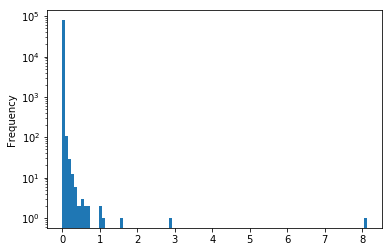

In [41]:
#show a histogram with 100 bins
popular_words['max'].plot.hist(bins=100, log=True)

#### Step 5: Look at just the 1000 most popular words
- Note that the shape of the distribution looks similar, but the Y axis is much smaller ($ 10^3 $ instead of $ 10^5 $), meaning we have removed many extremely uncommon words.

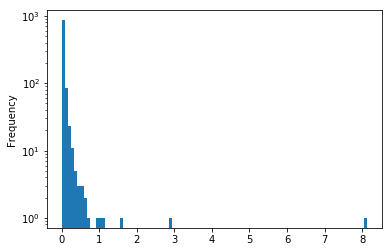

In [44]:
#select only the 1000 most popular words
popular_words = popular_words.sort_values(by='max', ascending=False).head(1000)

#show the histogram again
popular_words['max'].plot.hist(bins=100, log=True)

### Step 6: Figure out which words are more popular with one gender than the other
- Here we calculate how many times different the usage of words by men or women is, so if men use a word twice as often as women use the same word, then then men's use is 2 times different. 
- Like we saw before, both groups use the most popular words about the same amount.

In [46]:
def times_diff(row):
    #calculate how many times more men use a word than women
    #or vice versa if women use the word more
    if row.men > row.women:
        return row.men / row.women
    else:
        return -1 * (row.women / row.men)
    
popular_words['times_diff'] = popular_words.apply(times_diff, axis=1)
popular_words = popular_words.sort_values(by='max', ascending=False)

print('Most popular words:')
popular_words.head(10).round(3)

Most popular words:


,men,women,max,times_diff
i,7.665,8.119,8.119,-1.059
my,2.377,2.866,2.866,-1.206
you,1.611,1.534,1.611,1.050
love,0.683,1.115,1.115,-1.633
like,1.009,0.939,1.009,1.075
me,0.890,0.984,0.984,-1.105
friends,0.539,0.689,0.689,-1.278
good,0.646,0.652,0.652,-1.010
music,0.626,0.599,0.626,1.045
people,0.557,0.578,0.578,-1.037


#### Let's look at the words that are most different between them.

In [47]:
print('Words men use more than women:')
popular_words.sort_values(by='times_diff', ascending=False).head(15).round(3)

Words men use more than women:


,men,women,max,times_diff
computers,0.020,0.003,0.020,7.265
software,0.024,0.005,0.024,5.305
engineer,0.020,0.005,0.020,4.250
fixing,0.020,0.005,0.020,4.134
startup,0.019,0.005,0.019,3.493
guitar,0.055,0.017,0.055,3.211
cars,0.020,0.007,0.020,2.862
video,0.051,0.018,0.051,2.836
dj,0.018,0.006,0.018,2.728
motorcycle,0.022,0.008,0.022,2.665


In [48]:
print('Words women use more than men:')
popular_words.sort_values(by='times_diff', ascending=True).head(15).round(3)

Words women use more than men:


,men,women,max,times_diff
heels,0.002,0.017,0.017,-10.582
baking,0.007,0.031,0.031,-4.705
yoga,0.024,0.064,0.064,-2.661
shopping,0.007,0.018,0.018,-2.555
chocolate,0.026,0.061,0.061,-2.366
daughter,0.008,0.020,0.020,-2.366
sister,0.008,0.018,0.018,-2.307
hunger,0.008,0.018,0.018,-2.279
girl,0.055,0.126,0.126,-2.272
laughter,0.027,0.058,0.058,-2.183


# 3. Getting cleaner results

#### Stemming lets us count similar words like "dog" and "dogs" or " run" and "running" as the same word.
- Stemming grabs just the "stem" of each word (the stem of both "runs" and "running" is "run"). When the words are converted to their stems, the computer sees them as the same. [Learn more](https://en.wikipedia.org/wiki/Stemming)
- Stemming can be a little slow.

In [49]:
#snowball English (aka porter2) is the best general stemmer
stemmer = SnowballStemmer("english") 

def stem(t):
    out = []
    for w in t:
        out.append(stemmer.stem(w))
    return out

print("Stemming words from profile text...")
profiles['stems'] = profiles['tokens'].apply(stem)
profiles.stems.head()

Stemming words from profile text...


0    [crap, um, i, realli, quiet, first, i, realli,...
1    [fun, sinc, 1983, i, read, enough, seen, enoug...
2                                                [nan]
3    [famili, live, menlo, i, move, my, bff, san, f...
4    [i, person, thank, everi, day, happiest, beach...
Name: stems, dtype: object

#### These functions let us do the same things we did before without rewriting all the steps each time.
You don't have to worry about what's in them right now. Just run the cell and scroll down.

In [50]:
# functions for summarizing word use by a trait
def times_diff2(row, group, ref):
    if row[ref] > row[group]:
        return -1 * (row[ref] / row[group])
    else:
        return row[group] / row[ref]

#normally we wouldn't paste this function here because we already have it above
#but it helps to show in the lab
def flatten(series):
    l = []
    for x in series:
        l.extend(x) #each x is a list we want to unnest
    return l
    
def flatten2(series):
    l = []
    for x in series:
        tmp = set(x) #make the tokens into a set, thus dropping repeats
        tmp = list(tmp) #turn it back into a list we can attach to the other lists
        l.extend(tmp) 
    return l


def count(data, per_person):
    #count the people in each category
    l = len(data)

    #apply the right aggregation function, depending whether we want 
    #most common words, or words used by most people
    if per_person:
        data = flatten2(data)
    else:
        data = flatten(data)
            
    c = Counter(data)
    
    return c, l

def word_use(df, att, ref=None, per_person=False, undostems=False):
    #list all of the categories in this column
    types = list(df[att].value_counts().index.values)
    #variables that will store our results
    data = {}
    lens = {}
    
    print("Counting the words used by each group...")
    for t in types:
        #get the stems for each category
        tmp = df[df[att] == t].stems
        #count how often each is used
        data[t], lens[t] = count(tmp, per_person)
        
        #also compute the inverse of each category
        tmp = df[df[att] != t].stems
        data['not_'+str(t)], lens['not_'+str(t)] = count(tmp, per_person)        
        
    #convert those results to a pandas data frame for easy handling
    popular_words = pd.DataFrame(data)
    
    print('Calculating percentages...')
    # convert the counts in each column to percents
    for t in popular_words.columns:
        n = lens[t] #if we want percent of people
        
        if not per_person: #if we want percent of total words 
            n = popular_words[t].sum()
        
        popular_words[t] = (popular_words[t] / n) * 100
    
    print('Selecting the most popular words...')
    #find overall most popular words
    popular_words['max'] = popular_words.max(axis=1)
    #sort the words and select the top 1000 most popular
    popular_words = popular_words.sort_values(by='max', ascending=False)
    popular_words = popular_words.head(1000)

    print('Calculating most distinctive words...')
    #calculate the rate each type of person uses these words relative to others
    for t in types:
        r = ref
        
        if ref == None: #if we do not have a reference category, use the inverse
            r = 'not_'+str(t)
            
        if t != ref: #don't compare a trait to itself
            #apply our times_diff2 function
            popular_words['times_diff_'+str(t)] = popular_words.apply(times_diff2, 
                                                                 group=t, 
                                                                 ref=r, 
                                                                 axis=1)

    #remove the inverse columns we created
    popular_words = popular_words.drop(popular_words.filter(regex='not_'), axis=1)
    
    if undostems:
        print('Cleaning up word stems for readability...')
        popular_words = clean_index(popular_words, df)
    
    print('Done!')
    return popular_words

#### Let's try comparing men's and women's words again with stems this time
- The top words are somewhat different now that we're counting similar words as the same.
- We see word stems rather than whole words listed.

In [51]:
popular_words = word_use(profiles, att='sex')
popular_words = popular_words.sort_values(by='times_diff_m', ascending=False)
print("Men's words:")
popular_words.head(10).round(2)

Counting the words used by each group...
Calculating percentages...
Selecting the most popular words...
Calculating most distinctive words...
Done!
Men's words:


,f,m,max,times_diff_m,times_diff_f
softwar,0.00,0.02,0.02,5.15,-5.15
engin,0.01,0.04,0.04,3.57,-3.57
startup,0.01,0.02,0.02,3.25,-3.25
guitar,0.02,0.05,0.05,2.83,-2.83
comput,0.03,0.08,0.08,2.59,-2.59
motorcycl,0.01,0.03,0.03,2.54,-2.54
technolog,0.01,0.03,0.03,2.51,-2.51
basketbal,0.01,0.02,0.02,2.36,-2.36
dj,0.01,0.02,0.02,2.35,-2.35
video,0.02,0.06,0.06,2.31,-2.31


#### Those word stems in our table are a little hard to read. Let's change that.
- The `undostems=True` option converts the stems back to whole words before showing us the result.

In [52]:
popular_words = word_use(profiles, att='sex', undostems=True)
popular_words = popular_words.sort_values(by='times_diff_m', ascending=False)
print("Men's distinctive words:")
popular_words.head(10).round(2)

Counting the words used by each group...
Calculating percentages...
Selecting the most popular words...
Calculating most distinctive words...
Cleaning up word stems for readability...
Done!
Men's words:


,f,m,max,times_diff_m,times_diff_f
index,,,,,
software,0.00,0.02,0.02,5.15,-5.15
engineer,0.01,0.04,0.04,3.57,-3.57
startup,0.01,0.02,0.02,3.25,-3.25
guitar,0.02,0.05,0.05,2.83,-2.83
computer,0.03,0.08,0.08,2.59,-2.59
motorcycle,0.01,0.03,0.03,2.54,-2.54
technology,0.01,0.03,0.03,2.51,-2.51
basketball,0.01,0.02,0.02,2.36,-2.36
dj,0.01,0.02,0.02,2.35,-2.35


In [53]:
popular_words = popular_words.sort_values(by='times_diff_f', ascending=False)
print("Women's distinctive words:")
popular_words.head(10).round(2)

Women's words:


,f,m,max,times_diff_m,times_diff_f
index,,,,,
heels,0.02,0.00,0.02,-7.35,7.35
bake,0.04,0.02,0.04,-2.58,2.58
yoga,0.06,0.02,0.06,-2.49,2.49
adore,0.02,0.01,0.02,-2.26,2.26
chicken,0.02,0.01,0.02,-2.22,2.22
chocolate,0.06,0.03,0.06,-2.18,2.18
daughter,0.02,0.01,0.02,-2.07,2.07
laughter,0.06,0.03,0.06,-2.07,2.07
hunger,0.02,0.01,0.02,-2.02,2.02


#### But, wait! Not all profiles have the same number of words. 
- What if a single man just wrote "computer" a thousand times and that is skewing our results?
- With `per_person=True` we can see which words are used by the most different people, rather than which words are most common out of all the words used.

In [54]:
popular_words = word_use(profiles, att='sex', per_person=True, undostems=True)
print("Men's words:")
popular_words.sort_values(by='times_diff_m', ascending=False).head(10).round(2)

Counting the words used by each group...
Calculating percentages...
Selecting the most popular words...
Calculating most distinctive words...
Cleaning up word stems for readability...
Done!
Men's words:


,f,m,max,times_diff_m,times_diff_f
index,,,,,
software,0.98,4.45,4.45,4.52,-4.52
engineer,2.04,6.75,6.75,3.30,-3.30
startup,1.21,3.80,3.80,3.14,-3.14
technology,2.43,5.92,5.92,2.44,-2.44
guitar,3.76,8.37,8.37,2.22,-2.22
computer,6.08,12.94,12.94,2.13,-2.13
pulp,1.84,3.92,3.92,2.13,-2.13
tech,2.77,5.81,5.81,2.10,-2.10
basketball,1.97,3.99,3.99,2.03,-2.03


In [55]:
print("Women's words:")
popular_words.sort_values(by='times_diff_f', ascending=False).head(10).round(2)

Women's words:


,f,m,max,times_diff_m,times_diff_f
index,,,,,
heels,3.49,0.48,3.49,-7.33,7.33
bake,8.18,3.16,8.18,-2.58,2.58
yoga,10.56,4.43,10.56,-2.38,2.38
adore,3.70,1.60,3.70,-2.31,2.31
chocolate,11.67,5.13,11.67,-2.28,2.28
chicken,3.74,1.70,3.74,-2.20,2.20
laughter,11.92,5.63,11.92,-2.12,2.12
daughter,3.57,1.69,3.57,-2.11,2.11
sister,5.87,2.83,5.87,-2.07,2.07


# 4. Your turn to try it with another trait

### Options (traits)
We have a lot more information about people than just whether they're men or women. Try the analysis again with one of these other traits. (Expand for a list.)

- age_group (How old someone is. Youngest users are 18.)
    - categories: ['10', '20', '30', '40', '50']
- body (self-described)
    - categories: ['average', 'fit', 'thin', 'overweight', 'unknown']
- alcohol_use
    - categories: ['yes', 'no']
- drug_use
    - categories: ['yes', 'no']
- edu (highest degree completed)
    - categories: ['`<HS`', 'HS', 'BA', 'Grad_Pro', 'unknown'] 
- race_ethnicity
    - categories: ['Asian', 'Black', 'Latinx', 'White', 'multiple', 'other']
- height_group (whether someone is over or under six feet tall)
    - categories: ['under_6', 'over_6']
- industry (what field they work in)
    - categories: ['STEM', 'business', 'education', 'creative', 'med_law', 'other'] 
- kids (whether they have children)
    - categories: ['yes', 'no']
- orientation
    - categories: ['straight', 'gay', 'bisexual']
- pets_likes (what pets they like)
    - categories: ['both', 'dogs', 'cats', 'neither']
- pets_has (what pets they have)
    - categories: ['both', 'dogs', 'cats', 'neither']
- pets_any (whether they have pets or not)
    - categories: ['yes', 'no']
- religion
    - categories: ['christianity', 'catholicism', 'judaism', 'buddhism', 'none', 'other'] 
- sex
    - categories: ['m', 'f']
- smoker
    - categories: ['yes', 'no']
- languages
    - categories: ['multiple', 'English_only'] 

### How to (steps)
#### Step 1a: Decide which of the traits above you want to look at.
#### Step 1b: Load the profile data.

In [56]:
profiles = pd.read_csv('data/clean_profiles.tsv', sep='\t')

#### Step 2a: If you want, limit the data to just men or women.
- For everyone, leave this code how it is.
- For only men, remove the `#`
- For only women, remove the `#` and change the `'m'` in this line to `'f'`

In [57]:
#profiles = profiles[profiles['sex'] == 'm']

#### Step 2b: If you're running this on your personal computer
Run this code to use just a sample of the data set, because the full data is big enough to crash most personal computers. You can make the sample bigger or smaller by changing the number here.

In [58]:
profiles = profiles.sample(20000)
profiles.shape

(20000, 29)

#### Step 3: Tokenize and stem the text for these profiles.

In [59]:
print("Tokenizing...")
profiles['tokens'] = profiles['text'].apply(clean, sw=sw)
print("Stemming...")
profiles['stems'] = profiles['tokens'].apply(stem)
print("Done!")

Tokenizing...
Stemming...
Done!


#### Step 4: Compute the word usage statistics for your chosen attribute.
You can change the code below:
- You can change `att='age_group'` to your attribute of interest (e.g. `pets_likes` or `orientation`)
- The `per_person` and `undostems` are the same as we saw before.

In [60]:
result = word_use(profiles, att='age_group', per_person=True, undostems=True)

Counting the words used by each group...
Calculating percentages...
Selecting the most popular words...
Calculating most distinctive words...
Cleaning up word stems for readability...
Done!


#### Step 5a: Look at the results.
First, let's just see what columns we have.

In [61]:
result.head(2).round(2)

,20,30,40,50,10,max,times_diff_20,times_diff_30,times_diff_40,times_diff_50,times_diff_10
index,,,,,,,,,,,
i,93.18,94.03,93.40,93.86,88.78,94.03,-1.01,1.01,-1.00,1.00,-1.05
my,89.04,89.92,90.06,90.84,78.88,90.84,-1.01,1.01,1.01,1.02,-1.14


#### Step 5b: Looking at the most distinctive words by category
You can change two things in this code:
1. Change `'times_diff_10'` to the name of the column you want to sort by, i.e. the column you want to see the most popular words in. 
2. Change the number in `head(10)` to a bigger or smaller number to see more or less rows of output.

You can paste this line into more cells below and change it again to show different groups.

In [62]:
result.sort_values(by='times_diff_10', ascending=False).head(10).round(2)

,20,30,40,50,10,max,times_diff_20,times_diff_30,times_diff_40,times_diff_50,times_diff_10
index,,,,,,,,,,,
idk,0.70,0.10,NaN,NaN,5.28,5.28,3.20,-6.04,NaN,NaN,14.06
1984,0.44,0.33,0.61,0.94,4.95,4.95,-1.32,-1.87,1.22,1.90,11.08
tumblr,0.84,0.28,0.04,NaN,4.62,4.62,2.58,-2.55,-15.81,NaN,9.10
transfer,0.96,0.36,0.20,0.10,4.95,4.95,2.24,-2.40,-3.69,-6.86,7.99
18,0.80,1.01,1.96,2.39,8.58,8.58,-1.98,-1.30,1.78,2.09,7.86
weeds,3.21,2.07,1.55,1.25,9.24,9.24,1.54,-1.40,-1.79,-2.15,3.67
haha,4.90,2.15,0.61,0.52,10.23,10.23,2.62,-1.82,-6.04,-6.64,3.19
college,14.67,7.26,5.95,8.01,32.01,32.01,1.90,-1.79,-1.98,-1.40,2.99
wanna,5.66,3.54,2.04,2.29,12.87,12.87,1.69,-1.39,-2.35,-1.99,2.98


In [63]:
result.sort_values(by='times_diff_20', ascending=False).head(10).round(2)

,20,30,40,50,10,max,times_diff_20,times_diff_30,times_diff_40,times_diff_50,times_diff_10
index,,,,,,,,,,,
graduate,11.77,3.93,2.77,2.39,4.62,11.77,3.33,-2.36,-2.93,-3.22,-1.62
idk,0.70,0.10,NaN,NaN,5.28,5.28,3.20,-6.04,NaN,NaN,14.06
haha,4.90,2.15,0.61,0.52,10.23,10.23,2.62,-1.82,-6.04,-6.64,3.19
tumblr,0.84,0.28,0.04,NaN,4.62,4.62,2.58,-2.55,-15.81,NaN,9.10
transfer,0.96,0.36,0.20,0.10,4.95,4.95,2.24,-2.40,-3.69,-6.86,7.99
potter,7.36,3.45,2.48,2.50,11.88,11.88,2.18,-1.80,-2.28,-2.17,2.29
grad,5.63,3.32,1.51,1.46,0.66,5.63,2.13,-1.34,-2.94,-2.88,-6.25
student,8.47,4.39,3.30,3.02,11.55,11.55,2.01,-1.64,-2.02,-2.12,1.87
fuck,4.97,2.93,1.47,1.25,5.28,5.28,1.99,-1.38,-2.72,-3.05,1.44


In [64]:
result.sort_values(by='times_diff_30', ascending=False).head(10).round(2)

,20,30,40,50,10,max,times_diff_20,times_diff_30,times_diff_40,times_diff_50,times_diff_10
index,,,,,,,,,,,
passport,2.52,5.57,5.17,1.77,0.33,5.57,-1.98,1.92,1.43,-2.21,-11.69
vacation,2.63,5.72,5.30,4.37,0.33,5.72,-2.03,1.79,1.37,1.08,-12.44
balance,4.33,9.86,11.20,9.99,1.65,11.20,-2.30,1.66,1.67,1.40,-4.46
trip,9.07,15.49,12.34,11.55,1.98,15.49,-1.54,1.60,1.07,-1.01,-5.96
yoga,4.58,9.23,10.22,8.43,0.33,10.22,-1.99,1.59,1.57,1.22,-21.41
national,3.12,4.91,3.63,3.64,2.31,4.91,-1.42,1.52,-1.05,-1.04,-1.65
minute,3.66,5.35,3.95,2.71,0.66,5.35,-1.27,1.50,-1.06,-1.57,-6.41
mix,4.10,6.74,6.44,5.10,2.64,6.74,-1.56,1.47,1.25,-1.04,-2.02
fortunately,1.68,3.48,4.85,3.33,0.66,4.85,-2.21,1.47,1.98,1.23,-4.20


In [65]:
result.sort_values(by='times_diff_40', ascending=False).head(10).round(2)

,20,30,40,50,10,max,times_diff_20,times_diff_30,times_diff_40,times_diff_50,times_diff_10
index,,,,,,,,,,,
sensual,0.29,1.11,3.75,6.66,0.33,6.66,-7.55,-1.26,3.91,6.47,-3.98
divorce,0.27,0.71,2.40,4.99,0.33,4.99,-5.47,-1.42,3.43,7.10,-2.78
daughter,0.77,2.07,5.66,9.78,NaN,9.78,-4.65,-1.11,3.24,5.29,NaN
intimacy,0.61,1.32,3.54,6.04,NaN,6.04,-3.68,-1.16,3.03,4.91,NaN
integrity,0.99,2.27,5.13,6.24,0.99,6.24,-3.31,1.06,2.90,3.16,-2.22
intimacy,0.53,1.04,2.61,4.27,0.33,4.27,-3.14,-1.14,2.81,4.37,-3.48
affectionate,0.73,2.24,4.24,4.89,0.33,4.89,-3.94,1.34,2.76,2.86,-5.72
generous,0.66,1.88,3.71,4.79,0.33,4.79,-3.83,1.24,2.74,3.23,-5.03
spiritual,1.80,4.62,9.29,12.70,NaN,12.70,-3.51,1.17,2.69,3.39,NaN


In [66]:
result.sort_values(by='times_diff_50', ascending=False).head(10).round(2)

,20,30,40,50,10,max,times_diff_20,times_diff_30,times_diff_40,times_diff_50,times_diff_10
index,,,,,,,,,,,
divorce,0.27,0.71,2.40,4.99,0.33,4.99,-5.47,-1.42,3.43,7.10,-2.78
retirement,0.57,1.24,1.18,5.72,NaN,5.72,-2.83,1.20,1.07,6.52,NaN
sensual,0.29,1.11,3.75,6.66,0.33,6.66,-7.55,-1.26,3.91,6.47,-3.98
daughter,0.77,2.07,5.66,9.78,NaN,9.78,-4.65,-1.11,3.24,5.29,NaN
intimacy,0.61,1.32,3.54,6.04,NaN,6.04,-3.68,-1.16,3.03,4.91,NaN
mutual,0.59,1.11,2.53,4.68,0.99,4.68,-3.01,-1.13,2.48,4.55,-1.22
intimacy,0.53,1.04,2.61,4.27,0.33,4.27,-3.14,-1.14,2.81,4.37,-3.48
companion,0.74,1.16,2.81,4.99,NaN,4.99,-2.50,-1.23,2.50,4.36,NaN
grown,1.30,1.96,2.04,6.35,0.66,6.35,-1.80,1.09,1.12,3.92,-2.82


# 5. What we learned
Expand for more.

### Sociology & Gender
1. Overall, the most common words in online dating are the same for men and women in San Fransisco. What they say about themselves is not that different. 
2. There are some words that men use much more often than women, and vice versa. These fit stereotypical gender roles: for example, men in San Fransisco are much more likely to talk about computers, startups, engineering, and sports. And women are much more likely to talk about food (e.g. baking and chocolate) or feelings (adore, laughter). 
3. There are many possible causes for these differences in word use. For example, it is often taboo for men to talk about their feelings, so they may mention them less here because of social expectations rather than because they are less emotional. Social factors can also increase expression: for instance, women typically do the majority of food preparation in American families, so it is not surprising that they are more likely than men to talk about it in dating profiles. 
4. Not every person conforms to these broad patterns. Only 10-20% of these men mention computers. A similar percent of the women mention baking. Some women talk about computers, and some men talk about baking. Most people aren't using these very gendered words at all. What we showed is that there are broad patterns of some topics being much more popular with men or women, and that these patterns line up with common cultural expectations of gender.

### Text analysis
1. **Tokenizing** is the process of splitting text into words (tokens). Simple approaches can separate words based on spaces, but punctuation, HTML, and other things can make this more complicated. 
2. **Stop words** are words that are common but don't give us much information. They're often removed before we do analysis.
3. **Stemming** lets us combine similar words like "runs" and "running" by looking at the stem of the words (in this case, "run"). 
4. Most words are not very common. [Oxford Dictionaries](https://en.oxforddictionaries.com/explore/how-many-words-are-there-in-the-english-language) lists over 171,000 currently used English words, but as we saw, only a few words show up in more than a few profiles. 